In [4]:
from architecture import MicrocolonyNet
import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import torch
from efficientnet_pytorch import EfficientNet
from PIL import Image
from torchvision import transforms
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from grad_cam import GradCAM

In [5]:
## User-defined arguments
root = '/data2/microcolony-data/test/20x-3h/'
ckpt = '/data/jyyi/microcolony-classification-results/ckpt/ckpt_weights_20x-3h.ckpt'
batch = 1
workers = 0
save_path = '/data/jyyi/microcolony-classification-results/gradcam/heatmap/'

In [6]:
""" My modified script """

device = "cpu"

## Initialize my trained model
target_layer = 'model.blocks.5.14'
model = MicrocolonyNet()
# model = model.load_from_checkpoint(ckpt)
model.to(device)
model.eval()
print('Model loaded')

for img_name in os.listdir(root):
    ## Images
    img_path = root + img_name
    img = Image.open(img_path)
    img = img.convert("RGB")
    img = np.array(img)
    image = A.Compose([
                    A.ToFloat(max_value=255),
                    A.Resize(224, 224),
                    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                    ToTensorV2()
                    ])(image=img)['image']
    raw_image = A.Compose([
                    A.Resize(224, 224),
                    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                    ])(image=img)['image']
    images = torch.stack([image]).to(device)

    ## Grad-CAM
    gcam = GradCAM(model=model)
    _, sorted_ids = gcam.forward(images)

    ## Visualization
    ids_1st = sorted_ids[:, [0]] # highest scoring category
    gcam.backward(ids=ids_1st)

    heatmap = gcam.generate(target_layer=target_layer)
    heatmap = heatmap.cpu().numpy().squeeze()
    heatmap = cm.turbo(heatmap)[..., :3] * 255.0
    heatmap = (heatmap.astype(np.float) + raw_image.astype(np.float)) / 2
    # plt.imshow(np.uint8(heatmap))
    # plt.show()
    plt.imsave(save_path+img_name, np.uint8(heatmap))


Model loaded


/home/jyyi/miniconda3/envs/microcolony/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/jyyi/miniconda3/envs/microcolony/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


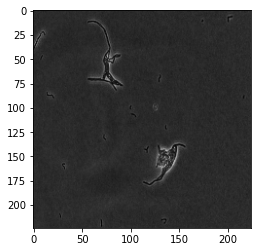

In [16]:
plt.imshow(raw_image)
plt.show()

In [18]:
""" gcam.forward(images) """

from torch.nn import functional as F
logits = model(images)
probs = F.softmax(logits, dim=1)
a,b = probs.sort(dim=1, descending=True)
b

tensor([[61, 76, 88, 46, 16, 24, 17, 10, 72, 75, 27, 69, 13, 60, 36, 45, 15, 64,
         90, 51, 71,  9, 99, 65, 63, 68, 22, 96, 47, 98, 56, 74, 62,  2,  4, 97,
         55, 20, 84, 29, 39,  0,  3, 42, 14, 89, 32, 12, 43, 66, 26, 54, 79, 58,
         28, 37, 19, 23, 11, 53, 18, 94, 35, 21, 33, 40, 57, 41, 70, 34, 49, 82,
          8, 83, 25,  7, 73, 86, 78, 92, 38, 67, 85,  5, 31, 30, 77, 48, 52, 91,
         59, 81, 44, 50,  1, 93, 95, 80,  6, 87]])

In [9]:
""" Example script - see https://github.com/kazuto1011/grad-cam-pytorch """

image_path = "/home/jyyi/Microcolony-Classification-Dev/gradcam/cat_dog.png"
device = "cpu"

# Model from torchvision
target_layer = "_blocks.15"
model = EfficientNet.from_pretrained("efficientnet-b0")
model.to(device)
model.eval()

# Images
image = Image.open(image_path)
raw_image = np.asarray(image)
image = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)(image)
images = torch.stack([image]).to(device)

gcam = GradCAM(model=model)
_, sorted_ids = gcam.forward(images)


Loaded pretrained weights for efficientnet-b0


/home/jyyi/miniconda3/envs/microcolony/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


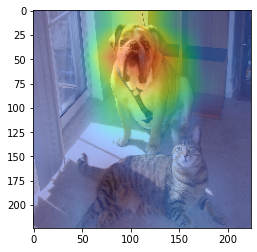

In [10]:
""" Example script - dog """

ids_1st = sorted_ids[:, [0]]  #243 'bull_mastiff'
gcam.backward(ids=ids_1st)
heatmap = gcam.generate(target_layer=target_layer)
heatmap = heatmap.cpu().numpy().squeeze()
heatmap = cm.turbo(heatmap)[..., :3] * 255.0
heatmap = (heatmap.astype(np.float) + raw_image.astype(np.float)) / 2
plt.imshow(np.uint8(heatmap))
plt.show()

/home/jyyi/miniconda3/envs/microcolony/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


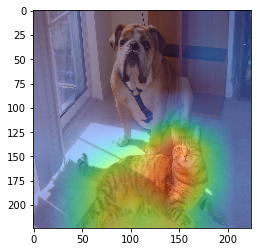

In [11]:
""" Example script - cat """

ids_4th = sorted_ids[:, [3]]  #282 'tiger_cat'
gcam.backward(ids=ids_4th)
heatmap = gcam.generate(target_layer=target_layer)
heatmap = heatmap.cpu().numpy().squeeze()
heatmap = cm.turbo(heatmap)[..., :3] * 255.0
heatmap = (heatmap.astype(np.float) + raw_image.astype(np.float)) / 2
plt.imshow(np.uint8(heatmap))
plt.show()